In [1]:
import dfmux_calc as d
import numpy as np
import matplotlib.pyplot as plt
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', 
          u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']

# 1 - Load LiteBIRD 40 GHz band parameters

In [2]:
x = np.loadtxt('litebird_noise.csv', skiprows=1, delimiter=',', dtype='str').T

k = 0
pix_id = x[0][k]
v = x[1].astype('float')[k]
psat = x[3].astype('float')[k]
popt = x[4].astype('float')[k]
pbias = x[5].astype('float')[k]
nep_ph = x[6].astype('float')[k]
nep_g = x[7].astype('float')[k]

nep_nonread = np.sqrt(nep_ph**2 + nep_g**2)
nep_read_req = np.sqrt(1.1**2 - 1.) * nep_nonread

# 2 - Define some constants

In [4]:
# wire harness
r_wh = 100.
c_wh = 100e-12
l_wh = 0.
wh = d.wire(r_wh, c_wh, l_wh)

#Other parasitics
l_strip = 10e-9
c_ground = 1e-12
r48 = 1e6
para = d.parasitics(l_strip, c_ground, r48)

# bolo properties (that I don't vary later)
loopgain = 10.
r_stray = 0.
tc = 0.17
tb = 0.1

# squid properties (that I don't vary later)
nei = 1e-12

# 3 - MC of Zt, Rdyn, Lin at 5.5 MHz

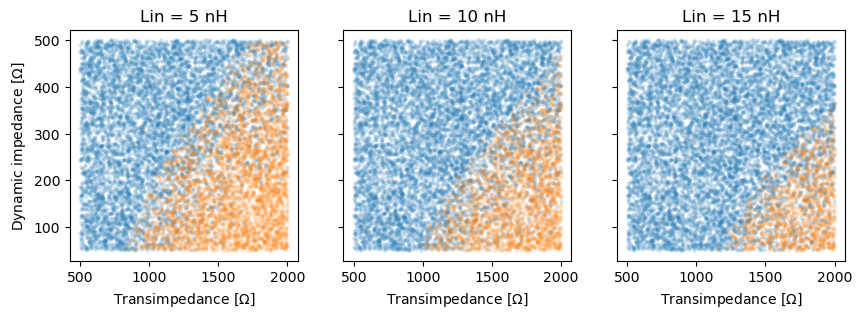

In [7]:
n = 10000

# SQUID
zt = np.random.uniform(500, 2000, n)
rdyn = np.random.uniform(50, 500, n)
lins = [5e-9, 10e-9, 15e-9]
nei = 1e-12

# bolo
r_tes = np.random.uniform(0.5, 1., n)
loopgain = 10.
rstray = 0.

fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
axs[0].set_ylabel('Dynamic impedance [$\Omega$]')
[axs[k].set_xlabel('Transimpedance [$\Omega$]') for k in range(3)]

for k, lin in enumerate(lins):
    sq = d.squid(zt, rdyn, nei, lin)
    bolo = d.bolo(r_tes, loopgain, r_stray, psat, popt, tc, tb)
    noise = d.dfmux_noise(sq, bolo, wh, para)
    noise.init_freq([5.5e6], skip_spice=True)
    
    nep_read = noise.total / bolo.si
    
    idx = nep_read.flatten() < nep_read_req
    
    
    axs[k].plot(zt[~idx], rdyn[~idx], '.', markeredgewidth=0., color=colors[0], alpha=0.2)
    axs[k].plot(zt[idx], rdyn[idx], '.', markeredgewidth=0., color=colors[1], alpha=0.2)
    axs[k].set_title(f'Lin = {round(lin*1e9)} nH')

plt.show()